# Churn Prediction Report


***

# Background

A ride-sharing company (Company X) is interested in **predicting rider retention**. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an account in **January 2014**. The data was pulled on July 1, 2014; we consider a user retained if they were **“active”** (i.e. took a trip) in the preceding 30 days (from the day the data was pulled). In other words, a user is "active" if they have taken a trip since June 1, 2014. 


The data, churn.csv, is in the data folder. The data are split into train and test sets. You are encouraged to tune and estimate your model's performance on the train set, then see how it does on the unseen data in the test set at the end.



# Objective

We would like you to use this data set to help understand **what factors are the best predictors for retention**, and offer suggestions to operationalize those insights to help Company X. Therefore, your task is not only to build a model that minimizes error, but also a model that allows you to interpret the factors that contributed to your predictions.


***

#  Steps of implementations

### EDA and data cleaning
1. Perform [EDA](#EDA) to familiarize ourselves with the data and check the quality of the data
2. Since our target label is missing, we need to [feature engineer the target label](#Feature-engineering)
3. We also need to do some [data cleaning](#Data-cleaning), such as, handling nan values and removing outliers 
4. For categorical variables, we will need to create [dummy variables](#Categorical-variables)
5. We can then [apply](#Apply-functions) all these cleanings and filtering functions to the dataset.

### Modeling and analysis
1. After the dataset is clean, we can start to build a the [baseline](#Baseline).
- Train a [simple random forest model](#Random-Forest), and check its performance.
- Train [mulitple models](#Train-different-models) to find the best model. In this case, our best model is [Gradient Boosting Classifier](#Gradient-Boosting-Classifier), which outperformed the baseline by 27% on accuracy and have a precision-recall score of 90%.
- Finally, we need to [analysize our result](#Final-Analysis) and make [recommendations](#Conclusion-and-recommendations) that will answer the original question.


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from collections import Counter
from sklearn.preprocessing import StandardScaler

from src import plot_roc_curve 
from src import functions



# EDA

#### Here is a detailed description of the data:

- city: city this user signed up in phone: primary device for this user
- signup_date: date of account registration; in the form YYYYMMDD
- last_trip_date: the last time this user completed a trip; in the form YYYYMMDD
- avg_dist: the average distance (in miles) per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- luxury_car_user: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [2]:
train = pd.read_csv("data/churn_train.csv", parse_dates= ['last_trip_date','signup_date'])

In [3]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


Since there is no **target** column, we will need to use the **signup_date and last_trip_date** columns to create the target labels.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
phone                     39681 non-null object
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.4+ MB


We also need to handle some **missing values**.

0.0 160.96


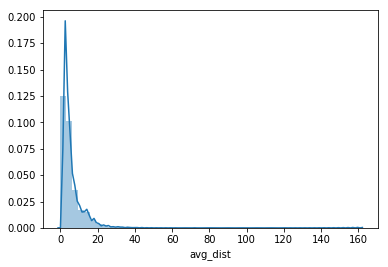

In [5]:
# checking the avg_dist column
sns.distplot(train.avg_dist);
print(min(train.avg_dist), max(train.avg_dist))

In [6]:
train[train.avg_dist == 0].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
403,0.0,5.0,NaN,3.0,Astapor,2014-01-26,iPhone,2014-01-16,100.0,1,False,0.0
579,0.0,5.0,NaN,1.0,Winterfell,2014-06-05,iPhone,2014-01-20,0.0,0,False,100.0
826,0.0,5.0,NaN,1.0,Astapor,2014-02-01,Android,2014-01-27,0.0,1,False,100.0
1108,0.0,3.0,5.0,1.0,Astapor,2014-02-17,iPhone,2014-01-01,0.0,0,False,0.0
1667,0.0,5.0,5.0,1.0,Winterfell,2014-01-11,Android,2014-01-10,0.0,1,False,100.0


Having 0 average distance mile does not make sense, as well as having greater than 120 average distance mile. Therefore, we will filter out these outliers.

In [7]:
# looking into catergorical columns
print('Types of cities:', train.city.unique())
print()
print()
print('Types of phones:', train.phone.unique())

Types of cities: ['Astapor' 'Winterfell' "King's Landing"]


Types of phones: ['Android' 'iPhone' nan]


***

## Feature engineering

### Create our target label

In [8]:
def add_target(df):
    '''
    Returns a data frame with a column added called within_last 30 days
    where 1 means the last ride was greater than 30 days away
    and 0 means the last ride was less than 30 days
    
    (ie.
    1 => CHURN
    0 => NO CHURN)
    
    '''
    df_copy = df.copy()
    
    latest_date = max(df_copy['last_trip_date'])
    
    time_diff = (latest_date - df_copy['last_trip_date'])
    churn = (time_diff > timedelta(days = 30)) * 1
    df_copy['churn'] = churn
    
    return df_copy

## Data cleaning

### Handling Nan values

In [9]:
def clean_avg_rating_of_driver(df):
    '''
    Cleaning the 'avg_rating_of_driver' column and creating 3 new columns:
        1. Column where we replace all np.nan to the median.
        2. Column where we create a scaled version of original
           while replacing all np.nan to median.
    '''

    df_copy = df.copy()

    # Create cleaned column replacing np.nan to median.
    median = df_copy.avg_rating_of_driver.median()
    df_copy['avg_rating_of_driver_median'] = df_copy.avg_rating_by_driver.fillna(median)

    
    # Normalized column based off median
    size = df_copy['avg_rating_of_driver_median'].shape[0]
    scaler = StandardScaler()
    df_copy['avg_rating_of_driver_normalized'] = scaler.fit_transform(df_copy['avg_rating_of_driver_median']\
                                                        .values.reshape(size,1))

    return df_copy


In [10]:
def cleaning_avg_rating_by_driver(df):

    df_copy = df.copy()

    #create cleaned column replacing np.nan to median.
    median = df_copy['avg_rating_by_driver'].median()
    df_copy['rating_by_driver_median'] = df_copy.avg_rating_by_driver.fillna(median)

    # Normalized column based off median
    size = df_copy['rating_by_driver_median'].shape[0]
    scaler = StandardScaler()

    df_copy['rating_by_driver_median_normalized'] = scaler.fit_transform(df_copy['rating_by_driver_median']\
                                                                         .values.reshape(size,1))

    return df_copy


### Outliers

In [11]:
def avg_dist_clean(df):
    
    df_copy = df.copy()
    # outliers on the left side
    df_copy.drop(df_copy[df_copy.avg_dist < 0.05].index, inplace = True)
    # outliers on the right side
    df_copy.drop(df_copy[df_copy.avg_dist > 120].index, inplace = True)
    
    return df_copy

## Categorical variables

In [12]:
def dummify_city(df):

    df_copy = df.copy()
    new_df = pd.get_dummies(df_copy, columns=['city'], drop_first=True)

    return new_df

In [13]:
def dummify_phone(df):
    
    df_copy = df.copy()
    new_df = pd.get_dummies(df_copy, columns=['phone'])
    
    return new_df

***

# Apply functions

In [14]:
# create target lable
train = add_target(train)
# clean average rating of driver
train = clean_avg_rating_of_driver(train)
# clean average rating by driver
train = cleaning_avg_rating_by_driver(train)
# clean avg_dist outliers
train = avg_dist_clean(train)
# dummify city variables
train = dummify_city(train)
# dummify phone variables
train = dummify_phone(train)

In [15]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,avg_rating_of_driver_median,avg_rating_of_driver_normalized,rating_by_driver_median,rating_by_driver_median_normalized,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,6.94,5.0,5.0,1.00,2014-05-03,2014-01-12,0.0,0,False,100.0,1,5.0,0.496532,5.0,0.495454,0,0,1,0
1,8.06,5.0,5.0,1.00,2014-01-26,2014-01-25,0.0,2,True,0.0,1,5.0,0.496532,5.0,0.495454,0,0,1,0
2,21.50,4.0,NaN,1.00,2014-05-21,2014-01-02,0.0,1,True,100.0,1,4.0,-1.739394,4.0,-1.739694,0,1,0,1
3,9.46,5.0,NaN,2.75,2014-01-10,2014-01-09,100.0,1,False,100.0,1,5.0,0.496532,5.0,0.495454,0,1,1,0
4,13.77,5.0,NaN,1.00,2014-05-13,2014-01-31,0.0,0,False,100.0,1,5.0,0.496532,5.0,0.495454,0,1,0,1


The dataset looks nice and clean the way we want it to be!

Now, we are ready to move on to building models!

***

# Baseline 

##  Predicting majority class

In [16]:
target = train.churn

In [17]:
print("The percentage of the dataset who churn or non-active in the last 30 days {:.2f}%" \
      .format(sum(target)/len(target)*100))

The percentage of the dataset who churn or non-active in the last 30 days 62.30%


### Majority Class

If we are only predicting if they used the service in the last 30 days, to be making predictions that are useful, we need to predict better than **62%**

***

# Random Forest

In [18]:
train.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'last_trip_date', 'signup_date', 'surge_pct', 'trips_in_first_30_days',
       'luxury_car_user', 'weekday_pct', 'churn',
       'avg_rating_of_driver_median', 'avg_rating_of_driver_normalized',
       'rating_by_driver_median', 'rating_by_driver_median_normalized',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

In [19]:
#Set up the Data
selected_coln = ['avg_dist', 'rating_by_driver_median_normalized', 
                 'avg_rating_of_driver_normalized', 'phone_iPhone',
                 'phone_Android',
                 'avg_surge','surge_pct','trips_in_first_30_days', 
                 'luxury_car_user', 'weekday_pct', 
                 "city_King's Landing", "city_Winterfell"]

df = train[selected_coln]
X = df.values
y = target
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=42)


In [20]:
#Train the Model
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

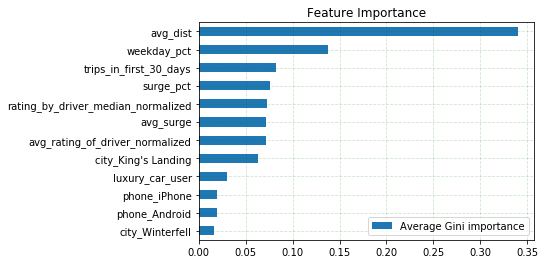



Accuracy =  74.78505668416648 %


In [21]:
#get the feature scores
feat_scores = pd.DataFrame({'Average Gini importance' : model.feature_importances_},
                           index=df.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')

#Plot
feat_scores.plot(kind='barh');
plt.grid(alpha = .2,color = 'g',ls = '--')
plt.title('Feature Importance')
plt.show()
print("\n")
print('Accuracy = ', np.sum(model.predict(X_test) == y_test)/len(y_test)*100,'%')

With the selected columns, the basic random forest classifier can already outperformed the majority class baseline by 21%!

Let's train more different tree-based models to see if we can get a better score!

***

# Train different models

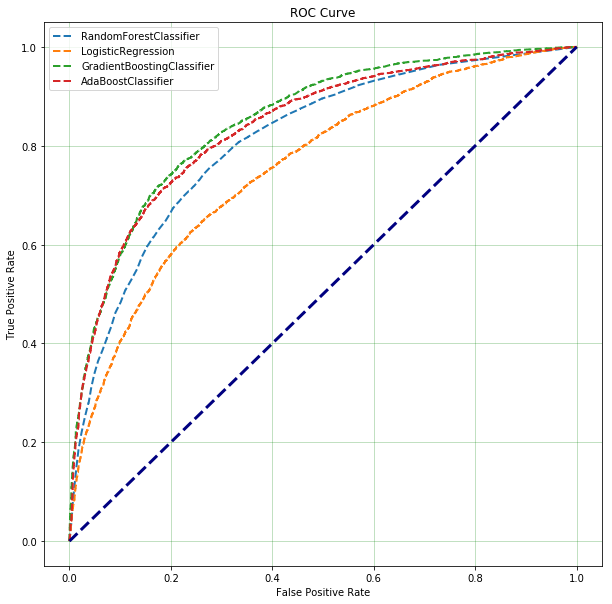

In [22]:
_,ax = plt.subplots(1,1,figsize = (10,10))

models = [RandomForestClassifier(n_estimators=50), \
          LogisticRegression(), \
          GradientBoostingClassifier(), \
          AdaBoostClassifier(GradientBoostingClassifier(), learning_rate=1)]  

plot_roc_curve.plot_roc(X,y,models,ax);

In [23]:
# sample cost matric
cost_matrix = np.array([[200, -100], [ 0,   0]]).T

In [24]:
for model in models:
    
    m,profits,p = functions.plot_profit_curve(model, cost_matrix, X_train, X_test,\
                      y_train, y_test,ax)
    
    print('The percentage of correct classification for \nmodel:',
          model.__class__.__name__,
          'is: ',
          np.round(np.sum(m == y_test)/len(y_test)*100,3),
         '%')
    print('-'*50)

The percentage of correct classification for 
model: RandomForestClassifier is:  74.587 %
--------------------------------------------------
The percentage of correct classification for 
model: LogisticRegression is:  71.924 %
--------------------------------------------------
The percentage of correct classification for 
model: GradientBoostingClassifier is:  78.536 %
--------------------------------------------------
The percentage of correct classification for 
model: AdaBoostClassifier is:  78.186 %
--------------------------------------------------


The Gradient Boosting Classifier have the best performance! Let's use it as our model and find what are the major features that are affecting customer churn rate!

## Gradient Boosting Classifier

In [66]:
final_model = GradientBoostingClassifier()
final_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Precision-recall

In [67]:
y_score = final_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.90


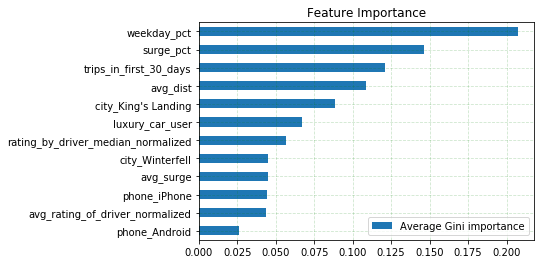



Accuracy =  78.53610286844707 %


In [68]:
feat_scores = pd.DataFrame({'Average Gini importance' : final_model.feature_importances_},
                           index=df.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')

#Plot
feat_scores.plot(kind='barh');
plt.grid(alpha = .2,color = 'g',ls = '--')
plt.title('Feature Importance')
plt.show()
print("\n")
print('Accuracy = ', np.sum(final_model.predict(X_test) == y_test)/len(y_test)*100,'%')

#### Accuracy score is now 79%! 

#### That is **27%** better than predicting the majority class. Average precision-recall score is 90%

***

# Final Analysis 

#### The top four factors are:

1. weekday_pct
- surge_pct
- first 30 days
- avg_dist

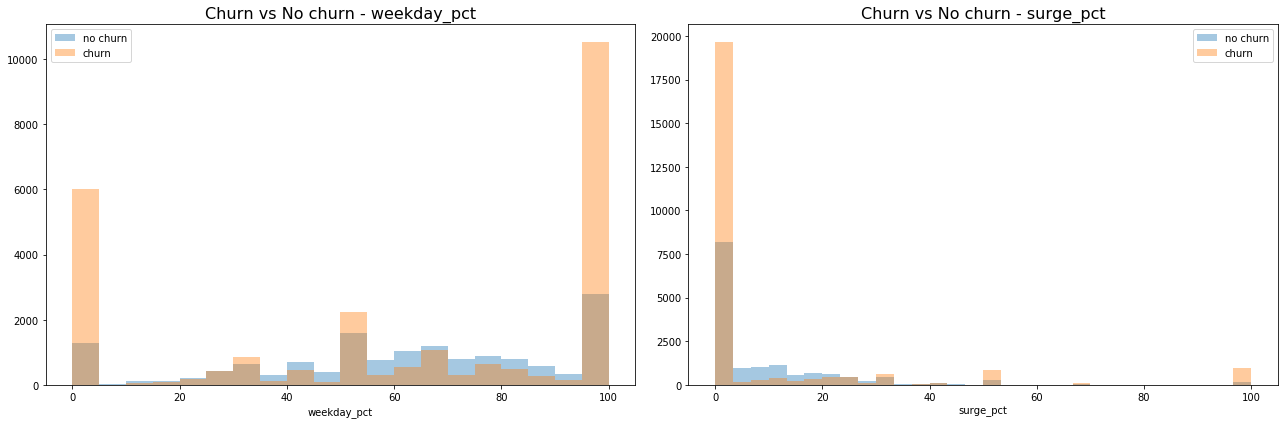

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(train[train.churn == 0].weekday_pct, bins = 20, kde=False, label = 'no churn', ax = ax[0])
sns.distplot(train[train.churn == 1].weekday_pct, bins = 20, kde=False, label = 'churn', ax = ax[0])
ax[0].set_title('Churn vs No churn - weekday_pct', fontsize=16)


sns.distplot(train[train.churn == 0].surge_pct, bins = 30, kde=False, label = 'no churn', ax = ax[1])
sns.distplot(train[train.churn == 1].surge_pct, bins = 30, kde=False, label = 'churn', ax = ax[1])
ax[1].set_title('Churn vs No churn - surge_pct', fontsize=16)


ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

Huge rate of churn at both ends of the graphs, when percentage is 0 or 100.

- 0 -> none of the trip occured on the weekdays. This group of users are not using the product as often, because they only use it on the weekends.

- 100 -> all trips occur on the weekdays. This group of users are most likely just had 1 trip and quit using the product.


Same thing for surge_rate. Huge rate of churn at both ends of the graphs, when percentage is 0 or 100.

- 0 -> have not taken trips with surge rate so far

- 100 -> the expensive surge rate might turned customers away

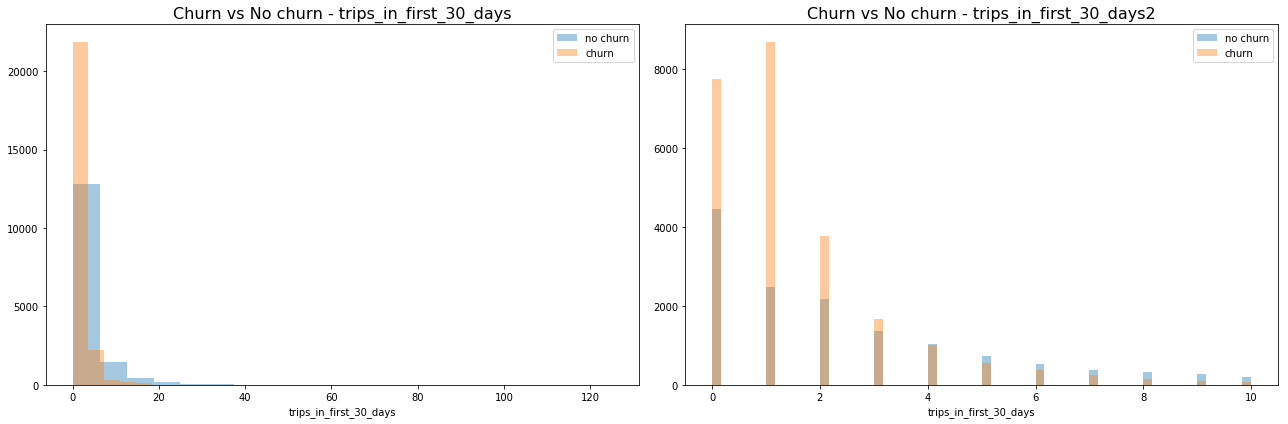

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(train[train.churn == 0].trips_in_first_30_days, bins = 20, kde=False, label = 'no churn', ax = ax[0])
sns.distplot(train[train.churn == 1].trips_in_first_30_days, bins = 20, kde=False, label = 'churn', ax = ax[0])
ax[0].set_title('Churn vs No churn - trips_in_first_30_days', fontsize=16)


sns.distplot(train[(train.trips_in_first_30_days <= 10) & (train.churn == 0)].trips_in_first_30_days, bins = 60, kde=False, label = 'no churn', ax = ax[1])
sns.distplot(train[(train.trips_in_first_30_days <= 10) & (train.churn == 1)].trips_in_first_30_days, bins = 60, kde=False, label = 'churn', ax = ax[1])
ax[1].set_title('Churn vs No churn - trips_in_first_30_days2', fontsize=16)


ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

- 0 or 1 trip in their first 30 days -> churn

- more than 2 trips in first 30 days -> no churn 

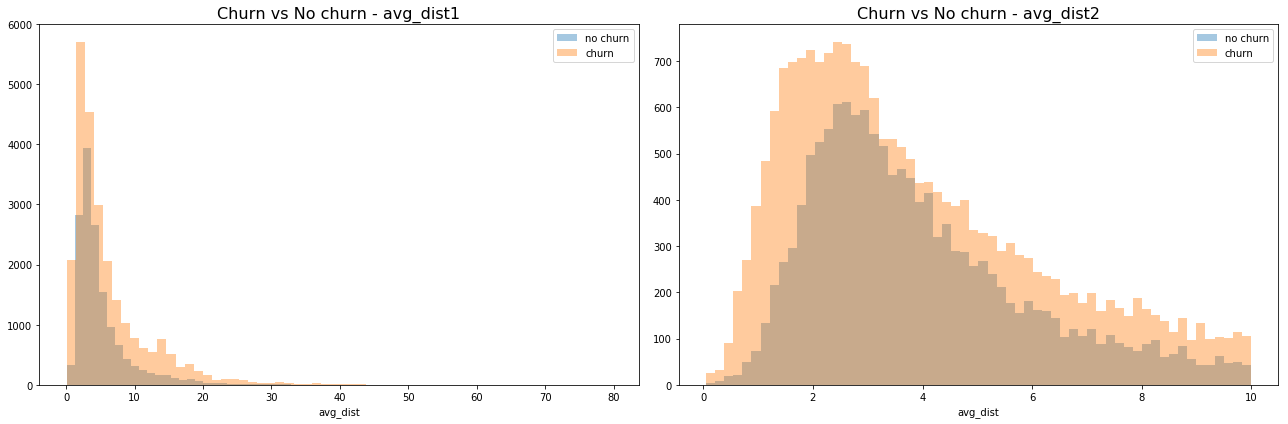

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(train[train.churn == 0].avg_dist, bins = 60, kde=False, label = 'no churn', ax = ax[0])
sns.distplot(train[train.churn == 1].avg_dist, bins = 60, kde=False, label = 'churn', ax = ax[0])
ax[0].set_title('Churn vs No churn - avg_dist1', fontsize=16)

# less than 10 miles
sns.distplot(train[(train.avg_dist < 10) & (train.churn == 0)].avg_dist, bins = 60, kde=False, label = 'no churn', ax = ax[1])
sns.distplot(train[(train.avg_dist < 10 )& (train.churn == 1)].avg_dist, bins = 60, kde=False, label = 'churn', ax = ax[1])
ax[1].set_title('Churn vs No churn - avg_dist2', fontsize=16)

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

- There are a lot of users who churned when their trip is less than 4 miles. 
- more than 4 miles -> active

## Conclusion and recommendations

Active users tend to:
   - have rides on both weekends and weekdays
   - have surge percentage around 1-20%
   - average distance trip of 3-20 miles
   - make more than 2 trips in their first 30 days

Non-active users tend to:
   - only rides either weekends or weekdays
   - have surge percentage either 0 or 100%
   - have short trips (average distance less than 3 miles) or very long trips (greater than 10 miles)
   - make less than 2 trips in their first 30 days

The behavior during their first few trips seeems like a strong indicator of whether they will be active or not. Thus, the marketing team can focus on driving more users to use more than 2 trips in their first month by providing promotions or etc.

In order to reduce the percentage of short trips, we implement some restrictions on these promotions. For instance, discounts can only be applied when trips are greater than 5 miles.


For active members, the engineering team can work on maintaining the surge percentage around 10-20% in order keep these users. The marketing team can also promote more rides on both weekends and weekdays for both active and non active groups.